In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
from keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm

In [61]:
df = pd.read_csv('cleaned_data.csv', on_bad_lines='skip', engine='python')
df

,resume_Text,job_description_text,decision,job_id
0,SummaryForward-thinking Project Management Pro...,Experienced in Salesforce Industries Communic...,0,0
1,Professional ProfileExpert in Functional Testi...,Experienced in Salesforce Industries Communic...,0,0
2,Professional SummaryA professional position in...,Experienced in Salesforce Industries Communic...,0,0
3,SummaryWorking with a $100 million company uti...,Experienced in Salesforce Industries Communic...,0,0
4,"Professional SummaryDependable, results-driven...",Experienced in Salesforce Industries Communic...,0,0
...,...,...,...,...
4824,"Professional SummaryDependable, results-driven...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4825,SummarySelf-motivated Data Analyst offering 8 ...,"Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4826,"Career OverviewDedicated, personable, and moti...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4827,"SummaryA results driven, detail-oriented data ...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189


In [62]:
df['combined_text'] = df['resume_Text'] + " " + df['job_description_text']


In [63]:
vectorizer = TfidfVectorizer(max_features=10000)
resume_tfidf = vectorizer.fit_transform(df['resume_Text'])
job_tfidf = vectorizer.transform(df['job_description_text'])
X = np.hstack([resume_tfidf.toarray(), job_tfidf.toarray()])
y = df['decision']


In [64]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, stratify=df['job_id'], random_state=42)


In [65]:
train_accuracies = {}
test_accuracies = {}

In [66]:
#Cosine Similarity Model
resume_vec = vectorizer.fit_transform(df['resume_Text'])
job_vec = vectorizer.transform(df['job_description_text'])
df['tfidf_cosine_score'] = cosine_similarity(resume_vec, job_vec).diagonal()


In [67]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
df['tfidf_lr_score'] = lr_model.predict_proba(X)[:, 1]
train_accuracies['LogReg'] = accuracy_score(y_train, lr_model.predict(X_train))
test_accuracies['LogReg'] = accuracy_score(y_test, lr_model.predict(X_test))
#df['log_rank'] = df.groupby('job_id')['log_score'].rank(ascending=False)

In [68]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
df['tfidf_rf_score'] = rf_model.predict_proba(X)[:, 1]
train_accuracies['RandomForest'] = accuracy_score(y_train, rf_model.predict(X_train))
test_accuracies['RandomForest'] = accuracy_score(y_test, rf_model.predict(X_test))

In [69]:
#LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
df['tfidf_svc_score'] = svc_model.decision_function(X)
train_accuracies['LinearSVC'] = accuracy_score(y_train, svc_model.predict(X_train))
test_accuracies['LinearSVC'] = accuracy_score(y_test, svc_model.predict(X_test))

In [70]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
df['tfidf_xgb_score'] = xgb_model.predict_proba(X)[:, 1]
train_accuracies['XGBoost'] = accuracy_score(y_train, xgb_model.predict(X_train))
test_accuracies['XGBoost'] = accuracy_score(y_test, xgb_model.predict(X_test))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:06:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
df['tfidf_lgb_score'] = lgb_model.predict_proba(X)[:, 1]
train_accuracies['LightGBM'] = accuracy_score(y_train, xgb_model.predict(X_train))
test_accuracies['LightGBM'] = accuracy_score(y_test, xgb_model.predict(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2093, number of negative: 1770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.735273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203668
[LightGBM] [Info] Number of data points in the train set: 3863, number of used features: 9108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541807 -> initscore=0.167619
[LightGBM] [Info] Start training from score 0.167619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [72]:
# Naive Bayes (Gaussian)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
df['tfidf_nb_score'] = nb_model.predict_proba(X)[:, 1]
train_accuracies['NaiveBayes'] = accuracy_score(y_train, nb_model.predict(X_train))
test_accuracies['NaiveBayes'] = accuracy_score(y_test, nb_model.predict(X_test))

In [73]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
df['tfidf_knn_score'] = knn_model.predict_proba(X)[:, 1]
train_accuracies['KNN'] = accuracy_score(y_train, knn_model.predict(X_train))
test_accuracies['KNN'] = accuracy_score(y_test, knn_model.predict(X_test))

In [74]:
# Keras NN
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_nn = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)
df['tfidf_nn_score'] = nn_model.predict(X).flatten()
train_accuracies['Keras NN'] = accuracy_score(y_train, (nn_model.predict(X_train).flatten() >= 0.5).astype(int))
test_accuracies['Keras NN'] = accuracy_score(y_test, (nn_model.predict(X_test).flatten() >= 0.5).astype(int))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [75]:
# Siamese Network
X1 = resume_tfidf.toarray()
X2 = job_tfidf.toarray()
y_array = np.array(df['decision'])
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y_array, stratify=df['job_id'], test_size=0.2, random_state=42)

embedding_dim = X1.shape[1]
input_a = Input(shape=(embedding_dim,))
input_b = Input(shape=(embedding_dim,))

def build_shared_network(input_dim):
    x = Input(shape=(input_dim,))
    h = Dense(256, activation='relu')(x)
    h = Dropout(0.3)(h)
    h = Dense(128, activation='relu')(h)
    return Model(x, h)

shared_network = build_shared_network(embedding_dim)
encoded_a = shared_network(input_a)
encoded_b = shared_network(input_b)

l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=lambda input_shapes: input_shapes[0])
merged = l1_distance([encoded_a, encoded_b])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_siamese = siamese_model.fit([X1_train, X2_train], y_train, validation_data=([X1_test, X2_test], y_test), batch_size=32, epochs=10, verbose=0)
df['tfidf_siamese_score'] = siamese_model.predict([X1, X2]).flatten()

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [76]:
siamese_train_pred = (siamese_model.predict([X1_train, X2_train]).flatten() >= 0.5).astype(int)
siamese_test_pred = (siamese_model.predict([X1_test, X2_test]).flatten() >= 0.5).astype(int)
train_accuracies['Siamese NN'] = accuracy_score(y_train, siamese_train_pred)
test_accuracies['Siamese NN'] = accuracy_score(y_test, siamese_test_pred)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [77]:
def print_all_model_accuracies():
    print("\n📊 Train vs Test Accuracy Summary:")
    print(f"{'Model':<20} {'Train Accuracy':<18} {'Test Accuracy':<18}")
    print("-" * 60)
    for name in train_accuracies:
        print(f"{name:<20} {train_accuracies[name]:<18.4f} {test_accuracies[name]:<18.4f}")

print_all_model_accuracies()


📊 Train vs Test Accuracy Summary:
Model                Train Accuracy     Test Accuracy     
------------------------------------------------------------
LogReg               0.7820             0.6563            
RandomForest         1.0000             0.6770            
LinearSVC            0.8732             0.6905            
XGBoost              0.9943             0.7060            
LightGBM             0.9943             0.7060            
NaiveBayes           0.7590             0.6149            
KNN                  0.7543             0.5963            
Keras NN             0.9995             0.7505            
Siamese NN           0.9953             0.7733            


In [78]:
def evaluate_model(name, y_true, y_score):
    acc = accuracy_score(y_true, y_score >= 0.5)
    print(f"{name}: Accuracy = {acc:.4f}")

evaluate_model("Cosine", y, df['tfidf_cosine_score'])


Cosine: Accuracy = 0.4589


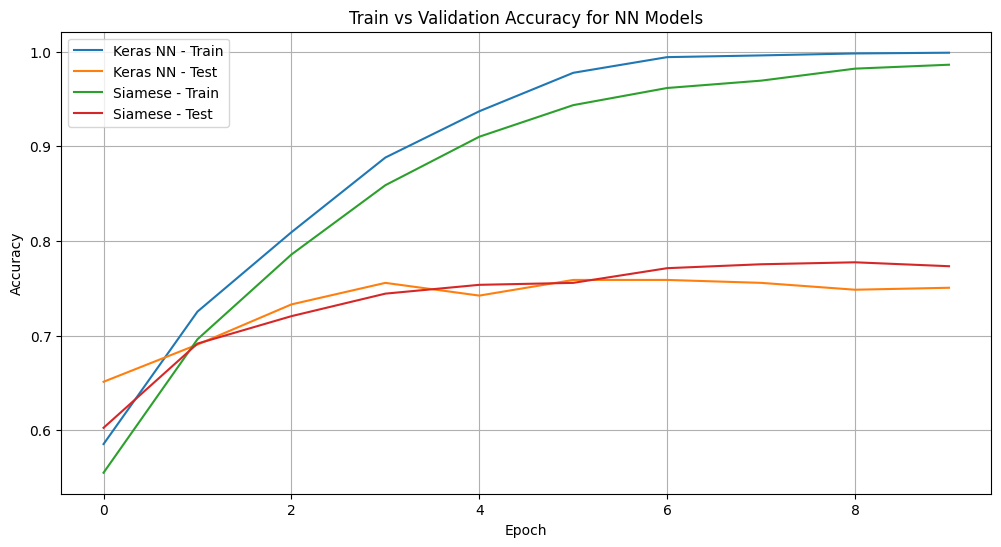

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['accuracy'], label='Keras NN - Train')
plt.plot(history_nn.history['val_accuracy'], label='Keras NN - Test')
plt.plot(history_siamese.history['accuracy'], label='Siamese - Train')
plt.plot(history_siamese.history['val_accuracy'], label='Siamese - Test')
plt.title('Train vs Validation Accuracy for NN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

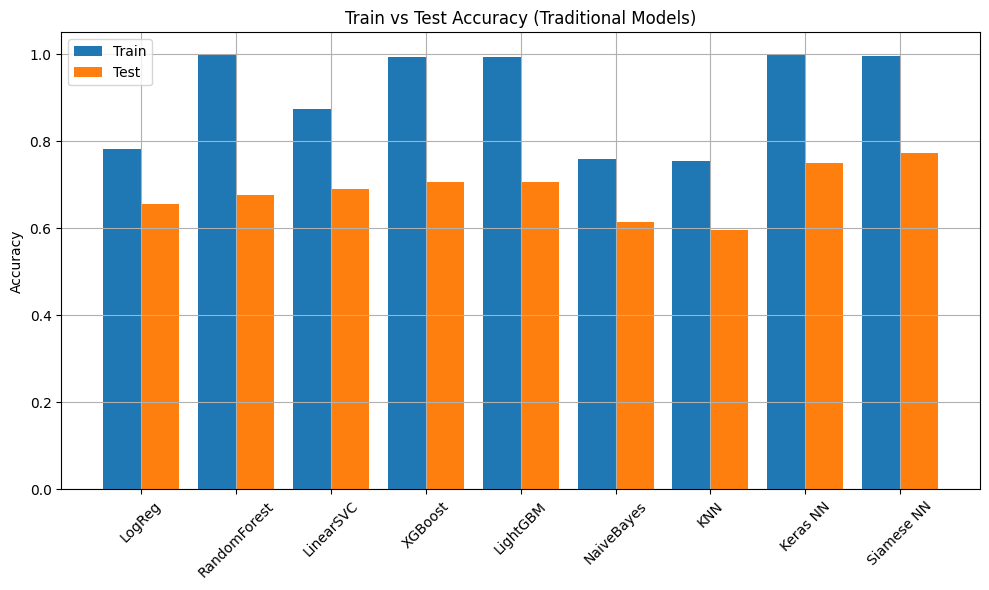

In [82]:
plt.figure(figsize=(10, 6))
labels = list(train_accuracies.keys())
train_vals = list(train_accuracies.values())
test_vals = list(test_accuracies.values())

x = range(len(labels))
plt.bar([i - 0.2 for i in x], train_vals, width=0.4, label='Train')
plt.bar([i + 0.2 for i in x], test_vals, width=0.4, label='Test')
plt.xticks(x, labels, rotation=45)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Traditional Models)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [83]:
df[[
    'job_id', 'decision',
    'tfidf_lr_score','tfidf_rf_score', 'tfidf_svc_score',
    'tfidf_xgb_score', 'tfidf_lgb_score','tfidf_nn_score', 'tfidf_nb_score', 'tfidf_knn_score',
    'tfidf_siamese_score']].to_csv("tfidf_model_scores.csv", index=False)